In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class mnistmodel_A2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=5,stride=1,padding=2)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=5,stride=2)
        self.dense1 = nn.Linear(in_features=64*12*12,out_features=32)
        self.dense2 = nn.Linear(in_features=32,out_features=2)
        self.dense3 = nn.Linear(in_features=2,out_features=1)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        #x = F.max_pool2d(x,2)
        x = F.relu(self.conv2(x))
        #x = F.max_pool2d(x,2)
        x = F.dropout(x,0.25)
        x = x.view(-1,64*12*12)
        x = F.sigmoid(self.dense1(x))
        x = F.dropout(x,0.5)
        x = F.sigmoid(self.dense2(x))
        x = F.sigmoid(self.dense3(x))

        return x
    

In [5]:
model = torch.load('mnist_model/modelA2.pth')

In [6]:
model

mnistmodel_A2(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
  (dense1): Linear(in_features=9216, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=2, bias=True)
  (dense3): Linear(in_features=2, out_features=1, bias=True)
)

In [7]:
def test(data_loader,ret=False):
    loder_test = data_loader
    model.eval()
    #torch.manual_seed(999)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loder_test:
            data = data.to(device)
            target = target.to(device).type(torch.float)
            #print(data.shape)
            output = model(data)
            #print(output.shape,target.shape)
            test_loss += F.binary_cross_entropy(output, target).item()
            #pred = output.data.max(1, keepdim=True)[1]
            pred = (output>0.5).type(torch.int)
            correct += (pred==target).sum()
        test_loss /= len(loder_test.dataset)
        #test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(loder_test.dataset),100. * correct / len(loder_test.dataset)))
        if ret == True:
            return (float(correct) / len(loder_test.dataset))

In [8]:
import getData_pt as getData

In [9]:
test_data = getData.normalMnist(data_type='test')

In [10]:
test(test_data.loader)


Test set: Avg. loss: 0.0020, Accuracy: 2113/2115 (99.91%)



/home/ml-lab/anaconda3/envs/ptorch/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [11]:
X = []
def get_activation(name):
    def hook(model, input, output):
        temp_o = output.detach().cpu().numpy()
        X.append(temp_o)
    return hook

In [12]:
model.dense2.register_forward_hook(get_activation('dense2'))
test(test_data.loader)


Test set: Avg. loss: 0.0020, Accuracy: 2114/2115 (99.95%)



In [13]:
#x = np.array([])
for i,xx in enumerate(X):
    if i==0:
        x = xx
    else:
        x=np.concatenate([x,xx])

In [14]:
x.shape

(2115, 2)

In [15]:
#x = F.tanh(torch.Tensor(x)).numpy()

In [16]:
y = test_data.labels.reshape(-1).numpy()

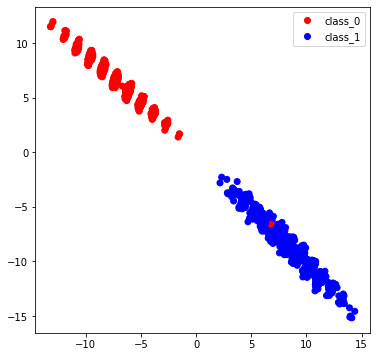

In [17]:
colors = ListedColormap(['red','blue'])
plt.figure(figsize=(6,6))
#plt.xlim(-6,6)
#plt.ylim(-6,6)
scatterplot = plt.scatter(x[:,0],x[:,1],c=y,cmap=colors)
plt.legend(handles=scatterplot.legend_elements()[0],labels=['class_0','class_1'])
#plt.title(title)
plt.show()

In [18]:
from sklearn.svm import SVC,LinearSVC

In [34]:
svm = SVC(C=1,kernel='linear').fit(x,y)

In [35]:
svm.support_vectors_[:, 0]

array([-1.63698041, -1.49828649,  6.77747917,  2.31445003,  2.16383886,
        2.78633404])

In [58]:
def svmpred_plot(svm,x,y):
    pred = svm.predict(x)
    class_plot = y + ~(pred==y)*2 
    colors_db = ['pink','cyan']
    plt.figure(figsize=(10, 10))
    plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=200,
                facecolors='none', zorder=10, edgecolors='k')
    #plt.scatter(x[:, 0], x[:, 1], c=y, zorder=10, cmap=colors,
    #            edgecolors='k')
    colors_dict = {0:'red',1:'blue',2:'green',3:'orange'}
    colors = ListedColormap(['red','blue','green','orange'])
    scatter = plt.scatter(x[:,0],x[:,1],c=[colors_dict[i] for i in class_plot],cmap=colors,label=class_plot,zorder=10,edgecolors='k')
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='class_0',markerfacecolor='red', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='class_1',markerfacecolor='blue', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='class_0 miss',markerfacecolor='green', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='class_1 miss',markerfacecolor='orange', markersize=7)
                         ]
    plt.legend(handles=legend_elements)
    x_min = -15
    x_max = 15
    y_min = -15
    y_max = 15

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = svm.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    #plt.figure(2, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=ListedColormap(colors_db))
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

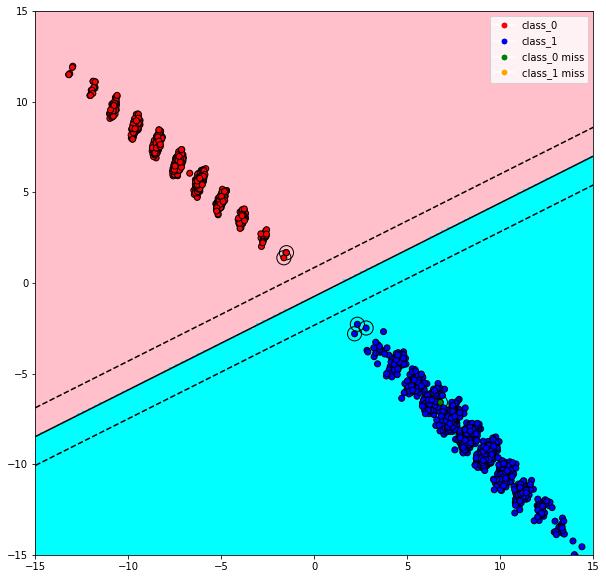

In [59]:
svmpred_plot(svm,x,y)

In [60]:
svm.support_vectors_

array([[-1.63698041,  1.39240348],
       [-1.49828649,  1.67296433],
       [ 6.77747917, -6.58736706],
       [ 2.31445003, -2.27751255],
       [ 2.16383886, -2.8042953 ],
       [ 2.78633404, -2.48355842]])

In [113]:
atk_data = getData.attackMnist(model,atk_loss=nn.BCELoss(),eps='s')

/home/ml-lab/anaconda3/envs/ptorch/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [114]:
X=[]
test(atk_data.loader)


Test set: Avg. loss: 0.0068, Accuracy: 1069/2115 (50.54%)



In [115]:
for i,xx in enumerate(X):
    if i==0:
        x_atk = xx
    else:
        x_atk=np.concatenate([x_atk,xx])

In [116]:
subvec_idx = []
for sub_vec in svm.support_vectors_:
    subvec_idx.append(np.where((x[:,0]==sub_vec[0]) & (x[:,1]==sub_vec[1]))[0])

In [117]:
subvec_idx=np.array(subvec_idx).reshape(-1)
subvec_idx

array([ 975, 1936, 2031,  927, 1664, 2040])

In [118]:
import itertools

In [119]:
x_alink = np.c_[x[subvec_idx],x_atk[subvec_idx]]
x_alink

array([[ -1.6369804,   1.3924035,  10.602777 , -11.324493 ],
       [ -1.4982865,   1.6729643,   8.2723055,  -8.420206 ],
       [  6.777479 ,  -6.587367 ,  11.959259 , -12.643436 ],
       [  2.31445  ,  -2.2775126,  -6.2128754,   5.0705376],
       [  2.1638389,  -2.8042953,  -9.737366 ,   8.469608 ],
       [  2.786334 ,  -2.4835584,  -8.64618  ,   6.736498 ]],
      dtype=float32)

(-15, 15)

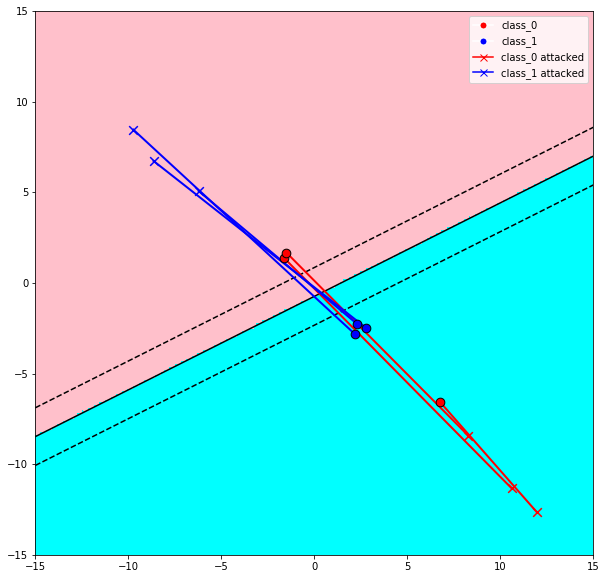

In [120]:
plt.figure(figsize=(10, 10))
colors_db = ['pink','cyan']
colors = ListedColormap(['red','blue'])
for subpoint,sublabel in zip(x_alink,y[subvec_idx]):
    marker = itertools.cycle(('o','x'))
    plt.plot(subpoint[[0,2]],subpoint[[1,3]],linewidth=2.0,c=colors.colors[int(sublabel)])
    plt.scatter(subpoint[[0]],subpoint[[1]],marker=next(marker), s=75,c=colors.colors[int(sublabel)],zorder=10,edgecolors='k')
    plt.scatter(subpoint[[2]],subpoint[[3]],marker=next(marker), s=75,c=colors.colors[int(sublabel)],zorder=10,edgecolors='k')
x_min = -15
x_max = 15
y_min = -15
y_max = 15

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = svm.decision_function(np.c_[XX.ravel(), YY.ravel()])
legend_elements = [Line2D([0], [0], marker='o', color='w', label='class_0',markerfacecolor='red', markersize=7),
               Line2D([0], [0], marker='o', color='w', label='class_1',markerfacecolor='blue', markersize=7),
               Line2D([0], [0], marker='x', color='red', label='class_0 attacked',markerfacecolor='red', markersize=7),
                   Line2D([0], [0], marker='x', color='blue', label='class_1 attacked',markerfacecolor='blue', markersize=7)
                     ]
plt.legend(handles=legend_elements)

# Put the result into a color plot
Z = Z.reshape(XX.shape)
#plt.figure(2, figsize=(4, 3))
plt.pcolormesh(XX, YY, Z > 0, cmap=ListedColormap(colors_db))
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-.5, 0, .5])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

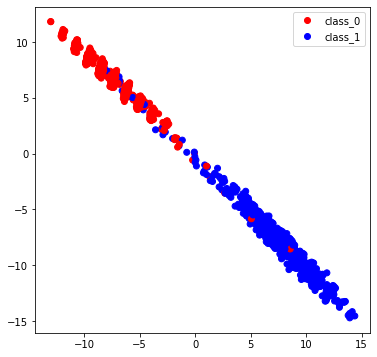

In [104]:
colors = ListedColormap(['red','blue'])
plt.figure(figsize=(6,6))
#plt.xlim(-6,6)
#plt.ylim(-6,6)
scatterplot = plt.scatter(x_atk[:,0],x_atk[:,1],c=y,cmap=colors)
plt.legend(handles=scatterplot.legend_elements()[0],labels=['class_0','class_1'])
#plt.title(title)
plt.show()

In [ ]:
#plt.clf()
pred = svm.predict(x_atk)
class_plot = y + ~(pred==y)*2 
colors_db = ['pink','cyan']
plt.figure(figsize=(10, 10))
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10, edgecolors='k')
#plt.scatter(x[:, 0], x[:, 1], c=y, zorder=10, cmap=colors,
#            edgecolors='k')
colors_dict = {0:'red',1:'blue',2:'green',3:'orange'}
colors = ListedColormap(['red','blue','green','orange'])
scatter = plt.scatter(x_atk[:,0],x_atk[:,1],c=[colors_dict[i] for i in class_plot],cmap=colors,label=class_plot,zorder=10,edgecolors='k')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='class_0',markerfacecolor='red', markersize=7),
               Line2D([0], [0], marker='o', color='w', label='class_1',markerfacecolor='blue', markersize=7),
               Line2D([0], [0], marker='o', color='w', label='class_0 miss',markerfacecolor='green', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='class_1 miss',markerfacecolor='orange', markersize=7)
                     ]
plt.legend(handles=legend_elements)
x_min = -15
x_max = 15
y_min = -15
y_max = 15

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = svm.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
#plt.figure(2, figsize=(4, 3))
plt.pcolormesh(XX, YY, Z > 0, cmap=ListedColormap(colors_db))
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-.5, 0, .5])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

In [ ]:
np.unique(class_plot)

In [ ]:
x_alink[0][[1,3]]

In [ ]:
subpoint[[0,2]]